In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
features_name = [i for i in train.columns.values if i not in ['connection_id', 'target']]

In [4]:
target = train['target']

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, train_size = 0.8, stratify = target, random_state = 2017)

In [6]:
def modelfit(model, train_data, train_label, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        params = {
            'objective' : xgb_param['objective'],
            'num_class':3,
            'base_score' : xgb_param['base_score'],
            'colsample_bylevel' : xgb_param['colsample_bylevel'],
            'colsample_bytree' : xgb_param['colsample_bytree'],
            'gamma' : xgb_param['gamma'],
            'eta' : xgb_param['learning_rate'],
            'max_delta_step' : xgb_param['max_delta_step'],
            'max_depth' : xgb_param['max_depth'],
            'min_child_weight' : xgb_param['min_child_weight'],
            'alpha' : xgb_param['reg_alpha'],
            'lambda': xgb_param['reg_lambda'],
            'scale_pos_weight' : xgb_param['scale_pos_weight'],
            'subsample' : xgb_param['subsample'],     
        }
           
        dtrain = xgb.DMatrix(data=train_data[predictors], label=train_label)
        cvresult = xgb.cv(params , dtrain, num_boost_round=model.get_params()['n_estimators'], stratified=True, nfold=cv_folds, metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        print(cvresult)
        print("########### n_estimators = %f" % cvresult.shape[0])
    
    # Fit the algorithm on the data
    model.fit(train_data[predictors], train_label,eval_metric='auc')
        
    # Predict training set:
    train_predictions = model.predict(train_data[predictors])
    train_predprob = model.predict_proba(train_data[predictors])[:,1]
    
    # Predict X_valid set:
    valid_predictions = model.predict(X_valid[predictors])
    valid_predprob = model.predict_proba(X_valid[predictors])[:,1]
        
    # Print model report:
    print("\nModel Report")
    print("Accuracy (Train): %.5g" % accuracy_score(train_label, train_predictions))
    # print("AUC Score (Train): %f" % roc_auc_score(train_label, train_predprob))
    print("Accuracy (Validation): %.5g" % accuracy_score(y_valid, valid_predictions))
    # print("AUC Score (Validation): %f" % roc_auc_score(y_valid, valid_predprob))
    
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [7]:
# Fit model using each importance as a threshold
def find_best_features_threshold(clf, predictors):
    print("feature importance values for all features")
    print(clf.feature_importances_)
    
    thresholds = np.sort(clf.feature_importances_)
    objective = clf.get_xgb_params()['objective']
    learning_rate = clf.get_xgb_params()['learning_rate']
    max_depth = clf.get_xgb_params()['max_depth']
    n_estimators = clf.get_xgb_params()['n_estimators']
    subsample = clf.get_xgb_params()['subsample']
    colsample_bytree = clf.get_xgb_params()['colsample_bytree']
    gamma = clf.get_xgb_params()['gamma']
    min_child_weight = clf.get_xgb_params()['min_child_weight']
    reg_alpha = clf.get_xgb_params()['reg_alpha']
    
    print("-------------------------------------------------------------------------------------")
    for thresh in thresholds:
        if thresh > 0.0000000999:            
            # select features using threshold
            selection = SelectFromModel(clf, threshold=thresh, prefit=True)
            select_X_train = selection.transform(X_train[predictors])
            # train model
            selection_model = xgb.XGBClassifier(objective=objective,learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, min_child_weight=min_child_weight, reg_alpha=reg_alpha)
            selection_model.fit(select_X_train, y_train, eval_metric='auc')
            # eval model
            select_X_test = selection.transform(X_valid[predictors])
            valid_pred = selection_model.predict(select_X_test)
            x_train_pred = selection_model.predict(select_X_train)
            # predictions = [round(value) for value in y_pred]
            accuracy_valid = accuracy_score(y_valid, valid_pred)
            accuracy_x_train = accuracy_score(y_train, x_train_pred )
            print("Thresh=%.10f, n=%d, Accuracy (Valid): %.5g, Accuracy (X_train): %.5g" % (thresh, select_X_train.shape[1], accuracy_valid, accuracy_x_train))

In [8]:
def predict_test_from_threshold_all_data(clf, predictors, threshold):
    
    thresholds = np.sort(clf.feature_importances_)
    objective = clf.get_xgb_params()['objective']
    learning_rate = clf.get_xgb_params()['learning_rate']
    max_depth = clf.get_xgb_params()['max_depth']
    n_estimators = clf.get_xgb_params()['n_estimators']
    subsample = clf.get_xgb_params()['subsample']
    colsample_bytree = clf.get_xgb_params()['colsample_bytree']
    gamma = clf.get_xgb_params()['gamma']
    min_child_weight = clf.get_xgb_params()['min_child_weight']
    reg_alpha = clf.get_xgb_params()['reg_alpha']
    
    selection = SelectFromModel(clf, threshold=threshold, prefit=True)
    select_X_train = selection.transform(train[predictors])
    selection_model = xgb.XGBClassifier(objective=objective,learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, min_child_weight=min_child_weight, reg_alpha=reg_alpha)
    selection_model.fit(select_X_train, target, eval_metric='auc')
    select_X_test = selection.transform(test[predictors])
    y_pred = selection_model.predict(select_X_test)
    return y_pred

In [9]:
def new_features_from_threshold(prev_features, threshold):
    new_features_name = []
    for i in range(len(prev_features)):
        if clf2.feature_importances_[i] > threshold:
            new_features_name.append(prev_features[i])
    
    return new_features_name

In [14]:
clf1 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

########### n_estimators = 190.000000

Model Report
Accuracy (Train): 0.78166
Accuracy (Validation): 0.7817


<IPython.core.display.Javascript object>


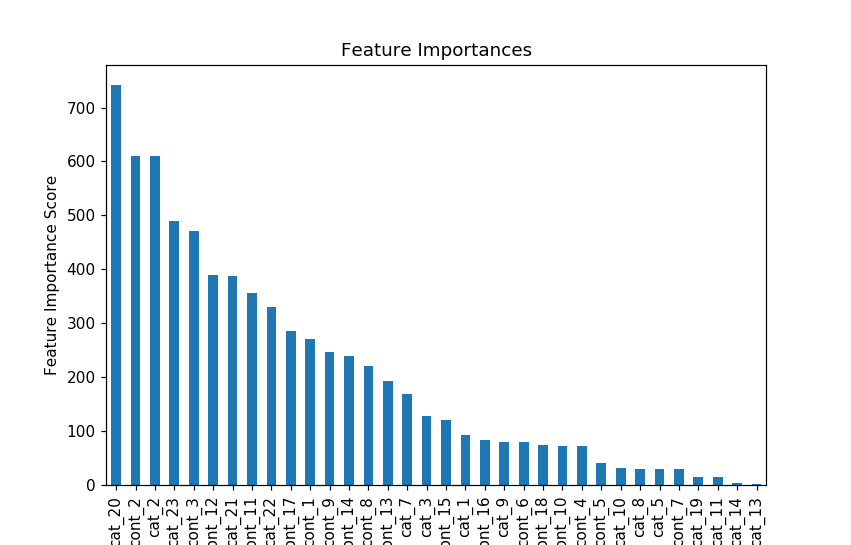

In [16]:
modelfit(clf1, train, target, features_name)

### Model 2 -   0.78142
objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=190, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001

In [6]:
clf2 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=190, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

In [13]:
clf2.fit(train[features_name], target,eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:softprob', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [22]:
pred2 = clf2.predict(test[features_name])

In [23]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred2
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb17.csv', index=False)

In [ ]:
find_best_features_threshold(clf2, features_name)

feature importance values for all features
[ 0.03856041  0.08726078  0.06726649  0.01028278  0.00571265  0.01142531
  0.00414167  0.03141959  0.03513282  0.01028278  0.05084262  0.05569837
  0.02742074  0.03413311  0.01713796  0.01185376  0.04070266  0.01056841
  0.01328192  0.08711797  0.01828049  0.          0.00428449  0.
  0.02399315  0.00428449  0.01142531  0.00457012  0.00199943  0.
  0.00014282  0.00057127  0.          0.          0.          0.
  0.00199943  0.10596972  0.05526992  0.04712939  0.06983719]
-------------------------------------------------------------------------------------
Thresh=0.0001428163, n=34, Accuracy (Valid): 0.7809, Accuracy (X_train): 0.78165
Thresh=0.0005712654, n=33, Accuracy (Valid): 0.78085, Accuracy (X_train): 0.78176
Thresh=0.0019994287, n=32, Accuracy (Valid): 0.78111, Accuracy (X_train): 0.78158
Thresh=0.0019994287, n=32, Accuracy (Valid): 0.78111, Accuracy (X_train): 0.78158
Thresh=0.0041416739, n=30, Accuracy (Valid): 0.78088, Accuracy (X_tr

In [23]:
new_features_name = new_features_from_threshold(features_name, 0.0019994)


Model Report
Accuracy (Train): 0.78162
Accuracy (Validation): 0.78161


<IPython.core.display.Javascript object>


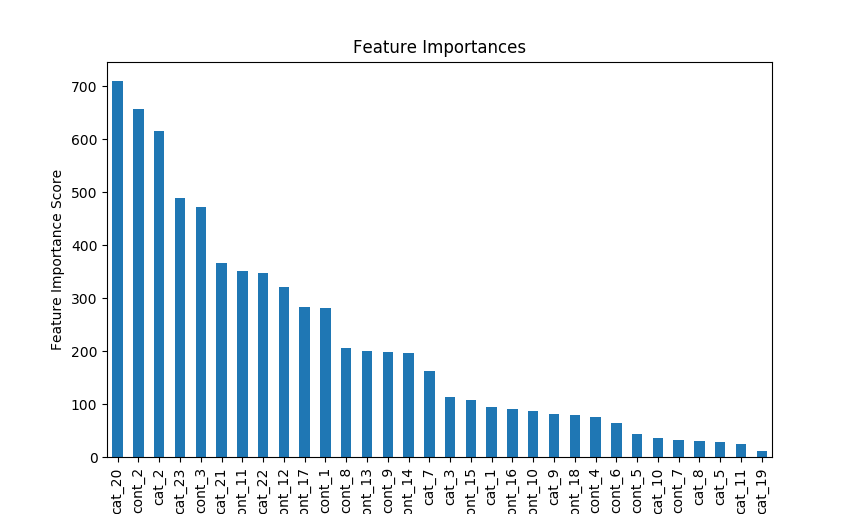

In [24]:
modelfit(clf2, train, target, new_features_name, False)

#### cv accuracy improved (maybe overfitting)

In [25]:
print(new_features_name)

['cont_1', 'cont_2', 'cont_3', 'cont_4', 'cont_5', 'cont_6', 'cont_7', 'cont_8', 'cont_9', 'cont_10', 'cont_11', 'cont_12', 'cont_13', 'cont_14', 'cont_15', 'cont_16', 'cont_17', 'cont_18', 'cat_1', 'cat_2', 'cat_3', 'cat_5', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11', 'cat_19', 'cat_20', 'cat_21', 'cat_22', 'cat_23']


so this new features with parameters<br>
objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=190, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001<br>
gives best local cv accuracy


### Model 3 -  0.78134

In [26]:
clf3 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=190, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

In [27]:
clf3.fit(train[new_features_name], target, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:softprob', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [28]:
pred3 = clf3.predict(test[new_features_name])

In [29]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred3
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb18.csv', index=False)

In [30]:
clf4 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=190, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)


Model Report
Accuracy (Train): 0.78168
Accuracy (Validation): 0.78102


<IPython.core.display.Javascript object>


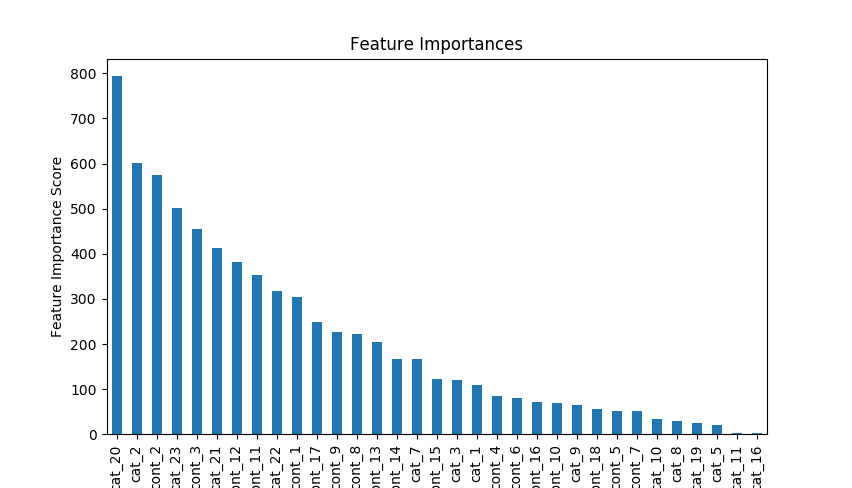

In [31]:
modelfit(clf4, X_train, y_train, features_name, False)

####  it seems like model trained with X_train and all features has lower CV  score than modle trained with X_train and important features

### Model 4 - 0.78128

In [32]:
clf4 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=190, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

In [33]:
clf4.fit(X_train[new_features_name], y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:softprob', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [34]:
pred4 = clf4.predict(test[new_features_name])

In [35]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred4
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb19.csv', index=False)

In [36]:
clf4 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

     test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0              1.026020           0.001133             1.025976   
1              0.964208           0.001379             0.964130   
2              0.911308           0.001162             0.911197   
3              0.865610           0.000873             0.865478   
4              0.826714           0.000921             0.826553   
5              0.792456           0.000671             0.792286   
6              0.762428           0.000623             0.762236   
7              0.736104           0.000807             0.735880   
8              0.712727           0.000867             0.712483   
9              0.691914           0.000826             0.691654   
10             0.673579           0.000786             0.673301   
11             0.657606           0.001052             0.657319   
12             0.642854           0.001052             0.642529   
13             0.629435           0.001007             0.62909

<IPython.core.display.Javascript object>


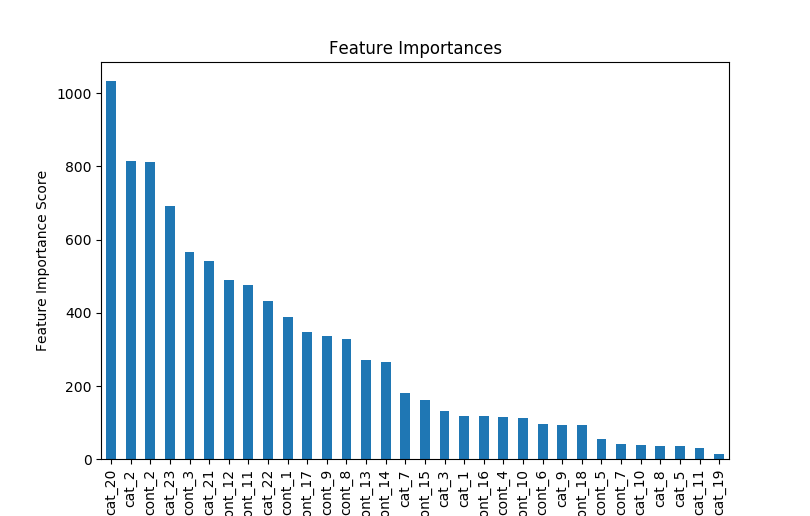

In [37]:
modelfit(clf4, train, target, new_features_name)

### Model 5 - 0.78134

In [38]:
clf5 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=4, n_estimators=257, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

In [39]:
clf5.fit(train[new_features_name], target, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=257, nthread=-1,
       objective='multi:softprob', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [40]:
pred5 = clf5.predict(test[new_features_name])

In [41]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred5
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb20.csv', index=False)


Model Report
Accuracy (Train): 0.78193
Accuracy (Validation): 0.78114


<IPython.core.display.Javascript object>


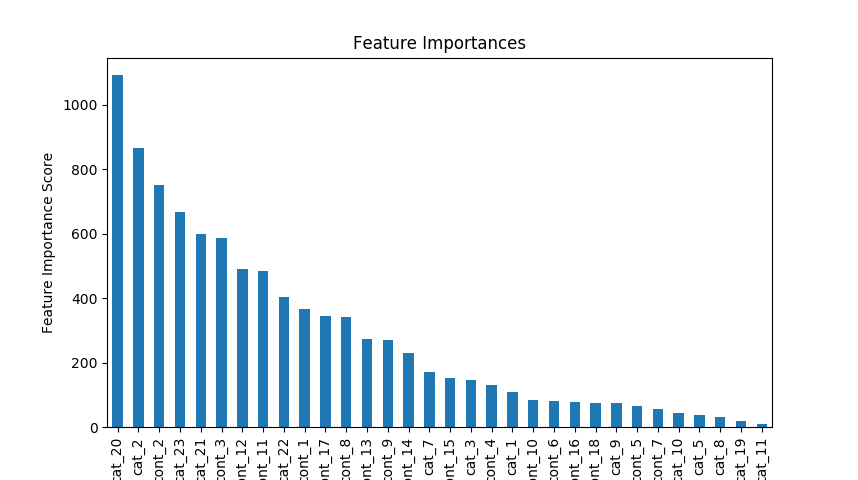

In [42]:
modelfit(clf5, X_train, y_train,new_features_name, False)

In [10]:
clf6 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=5, n_estimators=2000, subsample=0.85, colsample_bytree=0.6, gamma=0.15, min_child_weight= 3, reg_alpha=0.001)

     test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0              1.025078           0.000355             1.025037   
1              0.962913           0.000451             0.962845   
2              0.909973           0.000607             0.909851   
3              0.864465           0.000733             0.864295   
4              0.824753           0.000800             0.824528   
5              0.790325           0.000893             0.790057   
6              0.760123           0.000941             0.759790   
7              0.733595           0.000809             0.733197   
8              0.710346           0.000632             0.709911   
9              0.689457           0.000593             0.688977   
10             0.670994           0.000475             0.670477   
11             0.654439           0.000420             0.653870   
12             0.639698           0.000423             0.639090   
13             0.626324           0.000426             0.62568

<IPython.core.display.Javascript object>


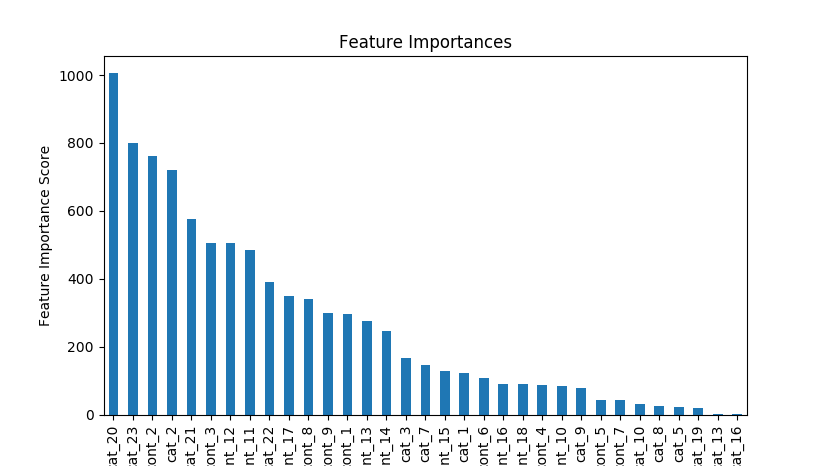

In [11]:
modelfit(clf6, train, target, features_name, early_stopping_rounds = 300)

### Model - 7 --  0.78136

In [12]:
clf7 = xgb.XGBClassifier(objective ='multi:softmax',learning_rate=0.1, max_depth=5, n_estimators=157, subsample=0.85, colsample_bytree=0.6, gamma=0.15, min_child_weight= 3, reg_alpha=0.001)


Model Report
Accuracy (Train): 0.7819
Accuracy (Validation): 0.7809


<IPython.core.display.Javascript object>


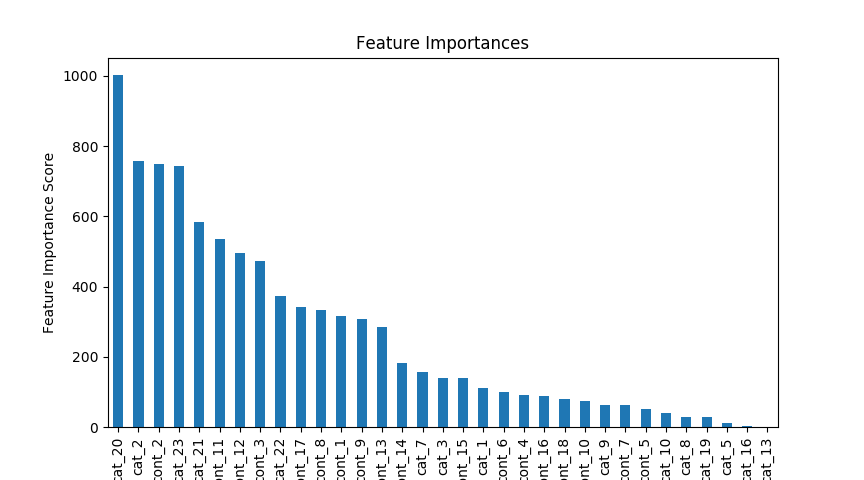

In [13]:
modelfit(clf7, X_train, y_train, features_name, False)

In [16]:
clf7.fit(train[features_name], target, eval_metric= 'auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.15, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=157, nthread=-1,
       objective='multi:softprob', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.85)

In [18]:
pred7 = clf7.predict(test[features_name])

In [19]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred7
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb21.csv', index=False)

###  Bagging

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

In [8]:
bagging = BaggingClassifier(base_estimator=clf2, n_estimators=10, random_state=2017, n_jobs=-1)

In [27]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2017)
results = cross_val_score(bagging, train[features_name], target, cv=kfold, scoring='accuracy')
print(results.mean())

0.780830090541


In [28]:
bagging.get_params()

{'base_estimator': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
        gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
        min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
        objective='multi:softmax', reg_alpha=0.001, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
 'base_estimator__base_score': 0.5,
 'base_estimator__colsample_bylevel': 1,
 'base_estimator__colsample_bytree': 0.6,
 'base_estimator__gamma': 0.1,
 'base_estimator__learning_rate': 0.1,
 'base_estimator__max_delta_step': 0,
 'base_estimator__max_depth': 4,
 'base_estimator__min_child_weight': 1,
 'base_estimator__missing': None,
 'base_estimator__n_estimators': 190,
 'base_estimator__nthread': -1,
 'base_estimator__objective': 'multi:softmax',
 'base_estimator__reg_alpha': 0.001,
 'base_estimator__reg_lambda': 1,
 'base_estimator__scale_pos_weight': 1,
 'base_estimator__seed': 0,
 'base_estimator__silent': True,
 'base_estima

In [35]:
bagging.fit(train[features_name], target)

BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:softmax', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=2017, verbose=0, warm_start=False)

In [36]:
valid_pred_bagging = bagging.predict(X_valid[features_name])

In [37]:
print("Accuracy (valid_pred_bagging): %.5g" % accuracy_score(y_valid, valid_pred_bagging))

Accuracy (valid_pred_bagging): 0.78144


In [38]:
xtrain_pred_bagging = bagging.predict(X_train[features_name])

In [39]:
print("Accuracy (xtrain_pred_bagging): %.5g" % accuracy_score(y_train, xtrain_pred_bagging))

Accuracy (xtrain_pred_bagging): 0.78144


In [40]:
train_pred_bagging = bagging.predict(train[features_name])

In [41]:
print("Accuracy (train_pred_bagging): %.5g" % accuracy_score(target, train_pred_bagging))

Accuracy (train_pred_bagging): 0.78144


#### on clf2 trained on entire train data gives train accuracy of 0.78166 and X_valid 0.78170
#### on bagging with clf2   trained on entire data set gives every data set accuracy of 0.78144 

### Model 8 - bagging with clf2  0.78131

In [42]:
pred8 = bagging.predict(test[features_name])

In [43]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred8
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb22.csv', index=False)

# #  # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [10]:
from sklearn.linear_model import LogisticRegression

In [13]:
# solver = 'sag', multi_class ='multinomial', max_iter = 300, n_jobs = -1, C = 0.5, random_state = 2017 
logistic_clf = LogisticRegression(random_state = 2017 )

In [57]:
lclf1.fit(train[features_name], target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2017, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
print("Accuracy (train_pred_bagging): %.5g" % accuracy_score(y_valid, lclf1.predict(X_valid[features_name])))

Accuracy (train_pred_bagging): 0.77293


In [59]:
lclf2 = LogisticRegression(solver = 'sag', multi_class ='multinomial', max_iter = 5000, n_jobs = -1, C = 0.5, random_state = 2017)

In [60]:
lclf2.fit(train[features_name], target)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=2017, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
lclf2.get_params()

{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 5000,
 'multi_class': 'multinomial',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 2017,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [64]:
print("Accuracy (train_pred_reg): %.5g" % accuracy_score(y_valid, lclf2.predict(X_valid[features_name])))

Accuracy (train_pred_reg): 0.69981


In [65]:
from sklearn import svm

In [66]:
lin_svc_clf = svm.LinearSVC()

In [67]:
lin_svc_clf.fit(train[features_name], target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [69]:
print("Accuracy (train_pred_reg): %.5g" % accuracy_score(y_valid, lin_svc_clf.predict(X_valid[features_name])))

Accuracy (train_pred_reg): 0.73357


In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
neigh_clf = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)

In [72]:
neigh_clf.fit(train[features_name], target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [73]:
print("Accuracy (train_pred_reg): %.5g" % accuracy_score(y_valid, neigh_clf.predict(X_valid[features_name])))

Accuracy (train_pred_reg): 0.76623


In [15]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
dt_clf = DecisionTreeClassifier(max_depth=8, min_samples_split=7, max_features='sqrt', random_state=2017)

### Ensembling  0.78098

In [17]:
from sklearn.ensemble import VotingClassifier

In [24]:
estimators = []
model1 = bagging
estimators.append(('baggingXGB', model1))
model2 = logistic_clf
estimators.append(('logistic', model2))
model3 = dt_clf
estimators.append(('cart', model3))
model4 = neigh_clf
estimators.append(('knn', model4))

In [25]:
# create the ensemble model
ensemble = VotingClassifier(estimators=estimators, voting='soft', weights=[0.8, 0.5, 0.6, 0.5], n_jobs=-1)

In [26]:
ensemble.fit(train[features_name], target)

VotingClassifier(estimators=[('baggingXGB', BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:soft...wski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))],
         n_jobs=-1, voting='soft', weights=[0.8, 0.5, 0.6, 0.5])

In [27]:
ensemble.get_params()

{'baggingXGB': BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
        gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
        min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
        objective='multi:softmax', reg_alpha=0.001, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
          random_state=2017, verbose=0, warm_start=False),
 'baggingXGB__base_estimator': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
        gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
        min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
        objective='multi:softmax', reg_alpha=0.001, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
 'baggingXGB__base_estimator__

In [28]:
import pickle

In [29]:
filehandler = open("ensemble.pickle","wb")
pickle.dump(ensemble,filehandler)
filehandler.close()

In [30]:
print("Accuracy (ensemble): %.5g" % accuracy_score(y_valid, ensemble.predict(X_valid[features_name])))

Accuracy (ensemble): 0.78129


In [31]:
pred_ensemble = ensemble.predict(test[features_name])

In [32]:
pred_ensemble

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [33]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred_ensemble
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb23.csv', index=False)

### Ensemble - 0.78134

In [41]:
estimators1 = []
model1 = bagging
estimators1.append(('baggingXGB', model1))
model2 = logistic_clf
estimators1.append(('logistic', model2))
model3 = clf2
estimators1.append(('xgb', model3))
model4 = neigh_clf
estimators1.append(('knn', model4))

In [42]:
# create the ensemble model
ensemble1 = VotingClassifier(estimators=estimators1, voting='soft', weights=[0.5, 0.2, 1.0 , 0.2], n_jobs=-1)

In [43]:
ensemble1.fit(train[features_name], target)

VotingClassifier(estimators=[('baggingXGB', BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:soft...wski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))],
         n_jobs=-1, voting='soft', weights=[0.5, 0.2, 1.0, 0.2])

In [45]:
ensemble1.get_params()

{'baggingXGB': BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
        gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
        min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
        objective='multi:softmax', reg_alpha=0.001, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
          random_state=2017, verbose=0, warm_start=False),
 'baggingXGB__base_estimator': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
        gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
        min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
        objective='multi:softmax', reg_alpha=0.001, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
 'baggingXGB__base_estimator__

In [47]:
print("Accuracy (ensemble): %.5g" % accuracy_score(y_valid, ensemble1.predict(X_valid[features_name])))

Accuracy (ensemble): 0.7815


In [48]:
pred_ensemble1 = ensemble1.predict(test[features_name])

In [49]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred_ensemble1
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb24.csv', index=False)

###  Ensenmble - 0.78114

In [50]:
estimators2 = []
model1 = bagging
estimators2.append(('baggingXGB', model1))
model2 = logistic_clf
estimators2.append(('logistic', model2))
model3 = clf2
estimators2.append(('xgb', model3))
model4 = neigh_clf
estimators2.append(('knn', model4))

In [51]:
# create the ensemble model
ensemble2 = VotingClassifier(estimators=estimators2, voting='soft', weights=[1, 1, 1, 1], n_jobs=-1)

In [52]:
ensemble2.fit(train[features_name], target)

VotingClassifier(estimators=[('baggingXGB', BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:soft...wski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))],
         n_jobs=-1, voting='soft', weights=[1, 1, 1, 1])

In [53]:
pred_ensemble2 = ensemble2.predict(test[features_name])
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred_ensemble2
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb25.csv', index=False)

In [55]:
estimators3 = []
model1 = bagging
estimators3.append(('baggingXGB', model1))
model2 = logistic_clf
estimators3.append(('logistic', model2))
model3 = neigh_clf
estimators3.append(('knn', model3))

In [56]:
# create the ensemble model
ensemble3 = VotingClassifier(estimators=estimators2, n_jobs=-1)

In [57]:
ensemble3.fit(train[features_name], target)

VotingClassifier(estimators=[('baggingXGB', BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=190, nthread=-1,
       objective='multi:soft...wski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))],
         n_jobs=-1, voting='hard', weights=None)

In [58]:
print("Accuracy (ensemble): %.5g" % accuracy_score(y_valid, ensemble3.predict(X_valid[features_name])))

Accuracy (ensemble): 0.78126


In [59]:
pred_ensemble3 = ensemble3.predict(test[features_name])
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred_ensemble3
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb26.csv', index=False)

###  ensemble is not working for me  shhhhiii